In [1]:
import numpy as np
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
0 Last batch accuracy: 0.97 Test accuracy: 0.9751
1 Last batch accuracy: 0.99 Test accuracy: 0.9837
2 Last batch accuracy: 1.0 Test accuracy: 0.987
3 Last batch accuracy: 0.97 Test accuracy: 0.9834
4 Last batch accuracy: 1.0 Test accuracy: 0.9881
5 Last batch accuracy: 1.0 Test accuracy: 0.9899
6 Last batch accuracy: 1.0 Test accuracy: 0.9908
7 Last batch accuracy: 1.0 Test accuracy: 0.9883
8 Last batch accuracy: 1.0 Test accuracy: 0.9872
9 Last batch accuracy: 1.0 Test accuracy: 0.9878


['conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0', 'conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0', 'conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0', 'conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0']
INFO:tensorflow:Restoring parameters from ./my_mnist_model
(3, 3, 32, 64)


Text(0.5, 1.0, 'conv1')

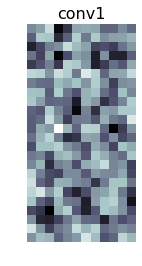

In [4]:
import tensorflow as tf

saver = tf.train.import_meta_graph("./my_mnist_model.meta")  
graph = tf.get_default_graph()
operations = graph.get_operations();
print([v.name for v in tf.trainable_variables()])  # those parameters learned
ker1 = graph.get_tensor_by_name("conv1/kernel:0")  # first convolutional layer
ker2 = graph.get_tensor_by_name("conv2/kernel:0")  # second convolutional layer
sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint("./"))  # the learned parameters
features1 = sess.run(ker1)  # get weights of the first convolutional layer
features2 = sess.run(ker2)  
print(features2.shape)  # how many values are in the second convolutional layer!

import numpy as np
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=4, **options):  # borrowed from DL1B.py
   # instances should be an array of 32 arrays of size 9 each for the 32 conv1 features
    size = 3
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'bone')
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(features1.flatten().reshape(3,3,32).transpose())  # you fill the new shape
plt.title("conv1", fontsize=16)



In [6]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_fashion_mnist_model")



0 Last batch accuracy: 0.86 Test accuracy: 0.874
1 Last batch accuracy: 0.89 Test accuracy: 0.8846
2 Last batch accuracy: 0.92 Test accuracy: 0.8915
3 Last batch accuracy: 0.91 Test accuracy: 0.8952
4 Last batch accuracy: 0.95 Test accuracy: 0.8908
5 Last batch accuracy: 0.93 Test accuracy: 0.907
6 Last batch accuracy: 0.94 Test accuracy: 0.91
7 Last batch accuracy: 0.92 Test accuracy: 0.9107
8 Last batch accuracy: 0.97 Test accuracy: 0.9104
9 Last batch accuracy: 0.98 Test accuracy: 0.9131


['conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0', 'conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0']
INFO:tensorflow:Restoring parameters from ./my_fashion_mnist_model
(3, 3, 32, 64)


Text(0.5, 1.0, 'conv1')

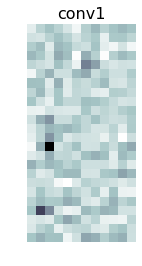

In [7]:
import tensorflow as tf

saver = tf.train.import_meta_graph("./my_fashion_mnist_model.meta")  
graph = tf.get_default_graph()
operations = graph.get_operations();
print([v.name for v in tf.trainable_variables()])  # those parameters learned
ker1 = graph.get_tensor_by_name("conv1/kernel:0")  # first convolutional layer
ker2 = graph.get_tensor_by_name("conv2/kernel:0")  # second convolutional layer
sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint("./"))  # the learned parameters
features1 = sess.run(ker1)  # get weights of the first convolutional layer
features2 = sess.run(ker2)  
print(features2.shape)  # how many values are in the second convolutional layer!

import numpy as np
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=4, **options):  # borrowed from DL1B.py
   # instances should be an array of 32 arrays of size 9 each for the 32 conv1 features
    size = 3
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'bone')
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(features1.flatten().reshape(3,3,32).transpose())  # you fill the new shape
plt.title("conv1", fontsize=16)
